In [2]:
library(ggplot2)
library(ChIPseeker)
library(GenomicFeatures)
library(tidyverse)
library(ggvenn)
library(cowplot)
library(patchwork)
library(ggsci)
library(ggplotify)
library(clusterProfiler)
library(readxl)
library(DESeq2)
library(ggrepel)
library(ggupset)
library(ClusterGVis)
library(edgeR)
library(WGCNA)
library(linkET)
library(ggpubr)
library(ggh4x)

In [3]:
files <- list.files("06_expr/",pattern="gtf")

In [4]:
fpkm <- NULL
for(f in files){
    re <- read.table(paste0("06_expr/",f),header=T,sep="\t")
    re <- re %>%
        dplyr::select(Gene=Gene.ID,FPKM) %>%
        mutate(Sample=gsub(".gtf","",f))
    fpkm <- rbind(fpkm,re)
}

In [5]:
fpkm <- spread(fpkm,Sample,FPKM)

In [6]:
load("06_counts/DEGs.RData")
DEGs <- DEGs %>%
    dplyr::filter(group!="None")

In [7]:
fpkm <- fpkm %>%
    dplyr::filter(Gene %in% DEGs$gene)

In [8]:
rownames(fpkm) <- fpkm$Gene

In [9]:
datExpr0 <- as.data.frame(t(fpkm[,-1])) 

In [10]:
gsg <- goodSamplesGenes(datExpr0, verbose = 3) 

 Flagging genes and samples with too many missing values...
  ..step 1
  ..Excluding 27 genes from the calculation due to too many missing samples or zero variance.
  ..step 2


In [11]:
if (!gsg$allOK) 
{ 
  # Optionally, print the gene and sample names that were removed: 
  if (sum(!gsg$goodGenes)>0) 
    print('ok')
  if (sum(!gsg$goodSamples)>0) 
    print('ok')
  # Remove the offending genes and samples from the data: 
  datExpr0 <- datExpr0[gsg$goodSamples, gsg$goodGenes] 
}

[1] "ok"


In [12]:
type <- "unsigned"
powers <- c(1:10, seq(from = 12, to = 30, by = 2))
# 计算不同软阈值下的网络拓扑结构
sft <- pickSoftThreshold(
  datExpr0,  # 预处理后的表达矩阵
  powerVector = powers,  # 待测试的power值
  networkType = type,  # 网络类型
  verbose = 5  # 输出详细计算过程
)

pickSoftThreshold: will use block size 4004.
 pickSoftThreshold: calculating connectivity for given powers...
   ..working on genes 1 through 4004 of 11172


Warning message:
"executing %dopar% sequentially: no parallel backend registered"


   ..working on genes 4005 through 8008 of 11172
   ..working on genes 8009 through 11172 of 11172
   Power SFT.R.sq  slope truncated.R.sq mean.k. median.k. max.k.
1      1   0.6940  3.050          0.914  3920.0   3850.00   5640
2      2   0.4020  0.994          0.935  1970.0   1890.00   3580
3      3   0.0125  0.122          0.932  1170.0   1090.00   2570
4      4   0.1610 -0.442          0.892   774.0    693.00   1980
5      5   0.4130 -0.775          0.908   546.0    469.00   1580
6      6   0.5660 -0.970          0.925   405.0    333.00   1300
7      7   0.6440 -1.110          0.925   311.0    246.00   1090
8      8   0.6860 -1.210          0.924   246.0    187.00    924
9      9   0.7270 -1.250          0.933   199.0    145.00    795
10    10   0.7650 -1.250          0.949   164.0    116.00    691
11    12   0.8100 -1.270          0.955   117.0     75.60    534
12    14   0.8270 -1.290          0.955    86.8     52.10    432
13    16   0.8330 -1.320          0.946    66.8     37.3

In [13]:
pt <- sft$fitIndices

In [14]:
soft_power <- 14

In [15]:
sft_r <- as.numeric(pt[pt$Power == soft_power, "SFT.R.sq"])
point_size <- 1
text_size <- 2.5

Warning message in geom_text(label = pt$Power, color = pt$text_color, size = text_size):
"Ignoring empty aesthetic: `colour`."
Warning message:
"The `size` argument of `element_rect()` is deprecated as of ggplot2 3.4.0.
ℹ Please use the `linewidth` argument instead."


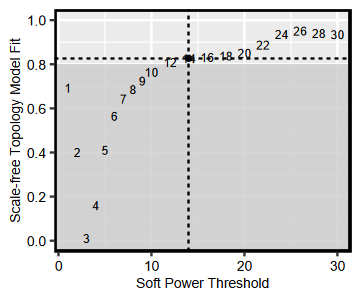

In [16]:
options(repr.plot.width=3, repr.plot.height=2.5)
FigureS5A <- pt %>% 
    ggplot(aes(x = Power, y = SFT.R.sq)) + geom_rect(data = pt[1, 
            ], aes(xmin = -Inf, xmax = Inf, ymin = -Inf, ymax = 0.8), 
            fill = "grey80", alpha = 0.8, color = NA) + geom_hline(yintercept = sft_r, 
            linetype = "dashed") + geom_vline(xintercept = soft_power, 
            linetype = "dashed") + geom_point(data = pt[pt$Power == 
            soft_power, c("Power", "SFT.R.sq")], aes(x = Power, 
            y = SFT.R.sq), inherit.aes = FALSE, color = "black", 
            size = point_size) + geom_text(label = pt$Power, 
            color = pt$text_color, size = text_size) + scale_y_continuous(limits = c(0, 
            1), breaks = c(0, 0.2, 0.4, 0.6, 0.8, 1)) + ylab("Scale-free Topology Model Fit") + 
            xlab("Soft Power Threshold") + theme(axis.line.x = element_blank(), 
                                                 axis.text=element_text(size=8,color='black'),
                                                 axis.title=element_text(size=8,color='black'),
            axis.line.y = element_blank(), panel.border = element_rect(colour = "black", 
                fill = NA, size = 1))
FigureS5A

In [17]:
mean_k <- as.numeric(pt[pt$Power == soft_power, "mean.k."])

Warning message in geom_text(label = pt$Power, color = pt$text_color, size = text_size):
"Ignoring empty aesthetic: `colour`."


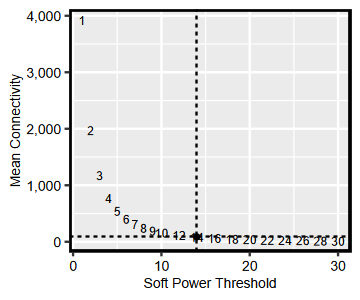

In [18]:
options(repr.plot.width=3, repr.plot.height=2.5)
FigureS5B <- pt %>% ggplot(aes(x = Power, y = mean.k.)) + 
                geom_hline(yintercept = mean_k, linetype = "dashed") + 
                geom_vline(xintercept = soft_power, linetype = "dashed") + 
                geom_point(data = pt[pt$Power == soft_power, 
                  c("Power", "mean.k.")], aes(x = Power, y = mean.k.), 
                  inherit.aes = FALSE, color = "black", size = point_size) + 
                geom_text(label = pt$Power, color = pt$text_color, 
                  size = text_size) + scale_y_continuous(labels = scales::comma) + 
                ylab("Mean Connectivity") + xlab("Soft Power Threshold") + 
                theme(axis.line.x = element_blank(), axis.line.y = element_blank(),
                                                 axis.text=element_text(size=8,color='black'),
                                                 axis.title=element_text(size=8,color='black'), 
                  panel.border = element_rect(colour = "black", 
                    fill = NA, size = 1))
FigureS5B

In [19]:
power <- sft$powerEstimate

In [20]:
#save(net,file='06_counts/net.RData')

In [19]:
load("06_counts/net.RData")

In [20]:
length(net$colors)

[1] 11172

In [21]:
net$colors[names(net$colors)=="EVM0010743"]

EVM0010743 
         0

In [22]:
module_gene <- table(net$colors) %>%
    as.data.frame() %>%
    arrange(desc(Freq)) %>%
    mutate(Var1=as.character(Var1)) %>%
    mutate(Var2=paste0("ME",Var1)) %>%
    mutate(Var2=factor(Var2,levels=Var2)) 

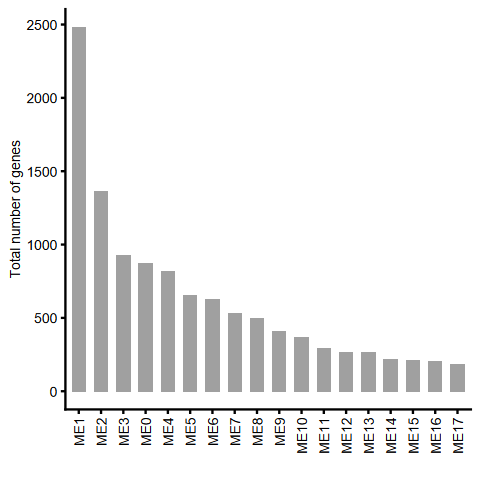

In [23]:
options(repr.plot.width=4, repr.plot.height=4)
FigureS5C <- module_gene %>%
    ggplot(aes(Var2,Freq))+
        geom_bar(stat='identity',width=0.6,fill=('#A0A0A0'))+
        #geom_text(aes(label=Freq),size=2.5,position = position_dodge(width = 0.8), vjust = -0.2)+
        xlab("")+ylab("Total number of genes")+
        theme_classic()+
        theme(axis.title=element_text(size=8),
        axis.text=element_text(size=8,color='black'),
        legend.position='none',
        axis.text.x=element_text(size=8, angle = 90, hjust=1,vjust=0.5))
FigureS5C

In [24]:
MEs <- net$MEs
MEs_col <- MEs
MEs_col <- orderMEs(MEs_col)

In [25]:
trait <- read_excel('trait.xlsx')
trait <- data.frame(trait,check.names = F)
rownames(trait) <- trait$Samples
trait <- trait[,-1]
sampleName <- rownames(datExpr0)
trait <- trait[match(sampleName, rownames(trait)), ]

In [26]:
nSamples <- nrow(datExpr0)
modTraitCor = cor(MEs_col, trait, use = "p")
modTraitP = corPvalueStudent(modTraitCor, nSamples)
geneModuleMembership = as.data.frame(cor(datExpr0, MEs_col, use = "p"))
MMPvalue = as.data.frame(corPvalueStudent(
             as.matrix(geneModuleMembership), nSamples))
geneTraitSignificance = cor(datExpr0, trait, use = "p")
GSPvalue  = corPvalueStudent(geneTraitSignificance, nSamples)

In [27]:
r <- reshape2::melt(modTraitCor)
p <- reshape2::melt(modTraitP)
mantel <- r %>%
  mutate(p=p$value,value=abs(value)) %>%
  dplyr::select(spec=Var2, env=Var1, r=value, p) %>% 
  mutate(rd = cut(r, breaks = c(-Inf, 0.2, 0.4, Inf),
                  labels = c("< 0.2", "0.2 - 0.4", ">= 0.4")),
         pd = cut(p, breaks = c(-Inf, 0.01, 0.05, Inf),
                  labels = c("< 0.01", "0.01 - 0.05", ">= 0.05")))

Warning message:
"`aes_()` was deprecated in ggplot2 3.0.0.
ℹ Please use tidy evaluation idioms with `aes()`
ℹ The deprecated feature was likely used in the ggplotify package.
  Please report the issue at <https://github.com/GuangchuangYu/ggplotify/issues>."


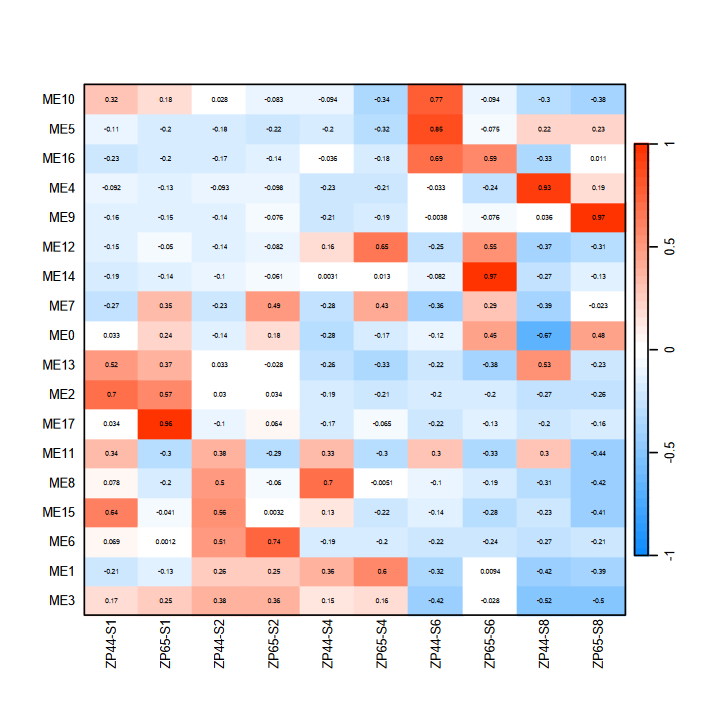

In [28]:
textMatrix = signif(modTraitCor, 2)
options(repr.plot.width=6, repr.plot.height=6)
Figure5A <- as.ggplot(~labeledHeatmap(Matrix = modTraitCor[,colnames(trait)[c(1,6,2,7,3,8,4,9,5,10)]], 
               xLabels = colnames(trait)[c(1,6,2,7,3,8,4,9,5,10)], 
               yLabels = colnames(MEs_col), 
               cex.lab = 0.6, 
               ySymbols = colnames(MEs_col), colorLabels = FALSE, 
               colors = blueWhiteRed(50),xLabelsAngle =90,
               textMatrix = textMatrix[,colnames(trait)[c(1,6,2,7,3,8,4,9,5,10)]], setStdMargins = FALSE, 
               cex.text = 0.3, zlim = c(-1,1),
               main = paste("")))
Figure5A

Warning message:
"Using `size` aesthetic for lines was deprecated in ggplot2 3.4.0.
ℹ Please use `linewidth` instead.
ℹ The deprecated feature was likely used in the linkET package.
  Please report the issue at <https://github.com/Hy4m/linkET/issues>."
Warning message in geom_square(aes(width = 0.8, height = 0.8)):
"Ignoring unknown aesthetics: width and height"
Warning message:
"Using the `size` aesthetic in this geom was deprecated in ggplot2 3.4.0.
ℹ Please use `linewidth` in the `default_aes` field and elsewhere instead.
ℹ The deprecated feature was likely used in the linkET package.
  Please report the issue at <https://github.com/Hy4m/linkET/issues>."


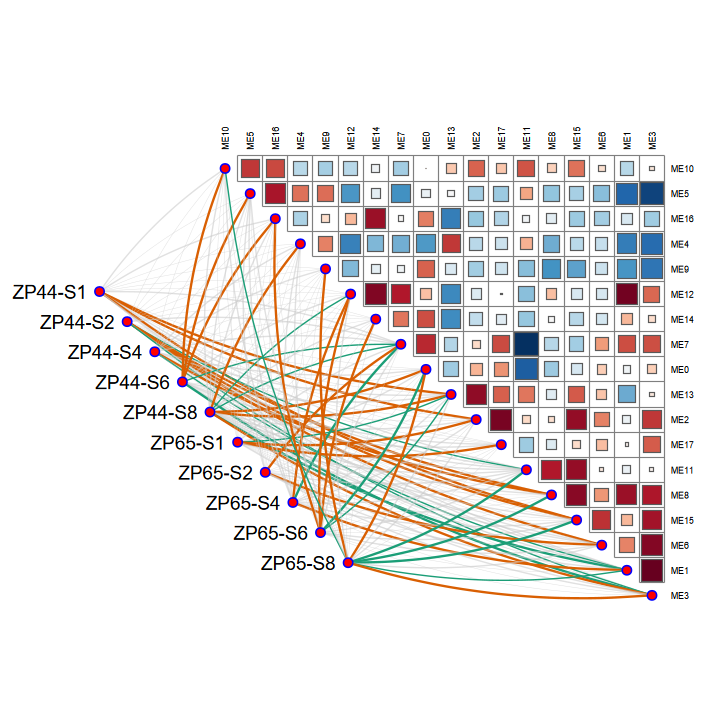

In [29]:
options(repr.plot.width=6, repr.plot.height=6)
Figure5A <- qcorrplot(correlate(MEs_col,engine='WGCNA',use='p'), type = "upper", diag = F) +
    geom_square(aes(width = 0.8, height = 0.8))+
  geom_couple(aes(colour = pd, size = rd), 
              data = mantel, 
              curvature = nice_curvature()) +
  scale_fill_gradientn(colours = rev(RColorBrewer::brewer.pal(11, "RdBu"))) +
  scale_size_manual(values = c(0.1, 0.3, 0.5)) +
  scale_colour_manual(values = color_pal(3)) +
  guides(size = guide_legend(title = "Pearson's r",
                             override.aes = list(colour = "grey35"), 
                             order = 2),
         colour = guide_legend(title = "Pearson's p", 
                               override.aes = list(size = 3), 
                               order = 1),
         fill = guide_colorbar(title = "Pearson's r", order = 3))+
        theme(legend.position='none',
            axis.title=element_text(size=8),
            axis.text=element_text(size=5,color='black'),
              plot.title = element_text(size = 8,color='black'))+
        xlab('')+ylab('')
Figure5A

In [30]:
stage <- c('ME7 vs S1','ME11 vs S1','ME15 vs S1','ME17 vs S1',
           'ME7 vs S2','ME8 vs S2','ME11 vs S2','ME15 vs S2',
           'ME7 vs S4','ME8 vs S4','ME11 vs S4','ME12 vs S4',
           'ME0 vs S6','ME5 vs S6','ME7 vs S6','ME10 vs S6','ME11 vs S6','ME12 vs S6','ME14 vs S6',
           'ME0 vs S8','ME4 vs S8','ME9 vs S8','ME11 vs S8','ME13 vs S8')

Warning message:
"The `size` argument of `element_line()` is deprecated as of ggplot2 3.4.0.
ℹ Please use the `linewidth` argument instead."


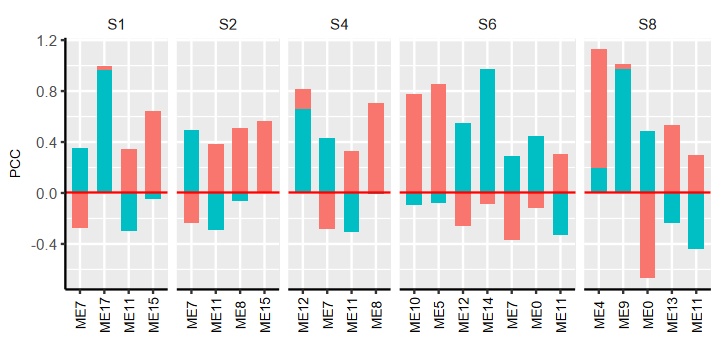

In [31]:
options(repr.plot.width=6, repr.plot.height=3)
Figure5B <- modTraitCor %>%
    reshape2::melt() %>%
    mutate(Stage=str_extract(Var2,"-(\\w+)")) %>%
    mutate(Stage=gsub("-","",Stage)) %>%
    mutate(loquat=str_extract(Var2,"(\\w+)-")) %>%
    mutate(loquat=gsub("-","",loquat)) %>%
    mutate(Pair=paste0(Var1," vs ",Stage)) %>%
    dplyr::filter(Pair %in% stage) %>%
    ggplot(aes(Var1,value,fill=loquat))+
        geom_bar(stat='identity',width=0.6)+
facet_grid(~Stage,scale='free_x',space = "free_x")+ylab("")+
geom_hline(yintercept = 0, color = "red", linetype = "solid")+
theme(strip.background = element_rect(color="white",fill='white'),
      axis.text.x = element_text(size=8,color='black',angle=90,hjust=0.5,vjust=0.5),
      legend.position='none',axis.title = element_text(size = 8,color='black'),
             axis.line = element_line(colour = "black",size = 0.5))+
ylab("PCC")+xlab("")
Figure5B

In [32]:
 modTraitCor %>%
    reshape2::melt() %>%
    mutate(Stage=str_extract(Var2,"-(\\w+)")) %>%
    mutate(Stage=gsub("-","",Stage)) %>%
    mutate(loquat=str_extract(Var2,"(\\w+)-")) %>%
    mutate(loquat=gsub("-","",loquat)) %>%
    mutate(Pair=paste0(Var1," vs ",Stage)) %>%
    dplyr::filter(Pair %in% stage) %>%
    dplyr::filter(Stage %in% c('S6') & Var1 %in% c("ME12"))

Var1,Var2,value,Stage,loquat,Pair
<fct>,<fct>,<dbl>,<chr>,<chr>,<chr>
ME12,ZP44-S6,-0.2523034,S6,ZP44,ME12 vs S6
ME12,ZP65-S6,0.5478023,S6,ZP65,ME12 vs S6


In [33]:
DEG <- function(count,sampleNames,comparison,rep=3){
    data <- count[,sampleNames]
    countData <- as.matrix(data)
    condition <- c(rep("control",rep),rep("treatment",rep))
    database <- data.frame(name=sampleNames, condition=condition)
    database$condition <- factor(database$condition)
    rownames(database) <- sampleNames
    dds <- DESeqDataSetFromMatrix(countData, colData=database, design= ~ condition)
    dds <- dds[ rowSums(counts(dds)) > 10, ]
    dds <- DESeq(dds)
    res <- results(dds,contrast=c("condition", "treatment", "control"))
    res <- res %>%
        as.data.frame() %>%
        mutate(comparison=comparison,gene=rownames(res))
    return(res)
}

In [34]:
count <- read.table("06_counts/Loquat_ZP.counts",header=T,check.names=F)

In [35]:
count <- count %>%
    dplyr::select(-c(Chr,Start,End,Strand,Length))

In [36]:
rownames(count) <- count$Geneid
count <- count[,-1]

In [37]:
ZP65_S1_S2 <- DEG(count=count,
    sampleNames= c("ZP65-S1_1","ZP65-S1_2","ZP65-S1_3","ZP65-S2_1","ZP65-S2_2","ZP65-S2_3"),
    comparison=c("ZP65-S1 vs ZP65-S2"))
ZP65_S2_S4 <- DEG(count=count,
    sampleNames= c("ZP65-S2_1","ZP65-S2_2","ZP65-S2_3","ZP65-S4_1","ZP65-S4_2","ZP65-S4_3"),
    comparison=c("ZP65-S2 vs ZP65-S4"))
ZP65_S4_S6 <- DEG(count=count,
    sampleNames= c("ZP65-S4_1","ZP65-S4_2","ZP65-S4_3","ZP65-S6_1","ZP65-S6_2","ZP65-S6_3"),
    comparison=c("ZP65-S4 vs ZP65-S6"))
ZP65_S6_S8 <- DEG(count=count,
    sampleNames= c("ZP65-S6_1","ZP65-S6_2","ZP65-S6_3","ZP65-S8_1","ZP65-S8_2","ZP65-S8_3"),
    comparison=c("ZP65-S6 vs ZP65-S8"))

estimating size factors

estimating dispersions

gene-wise dispersion estimates

mean-dispersion relationship

final dispersion estimates

fitting model and testing

estimating size factors

estimating dispersions

gene-wise dispersion estimates

mean-dispersion relationship

final dispersion estimates

fitting model and testing

estimating size factors

estimating dispersions

gene-wise dispersion estimates

mean-dispersion relationship

final dispersion estimates

fitting model and testing

estimating size factors

estimating dispersions

gene-wise dispersion estimates

mean-dispersion relationship

final dispersion estimates

fitting model and testing



In [38]:
ZP44_S1_S2 <- DEG(count=count,
    sampleNames= c("ZP44-S1_1","ZP44-S1_2","ZP44-S1_3","ZP44-S2_1","ZP44-S2_2","ZP44-S2_3"),
    comparison=c("ZP44-S1 vs ZP44-S2"))
ZP44_S2_S4 <- DEG(count=count,
    sampleNames= c("ZP44-S2_1","ZP44-S2_2","ZP44-S2_3","ZP44-S4_1","ZP44-S4_2","ZP44-S4_3"),
    comparison=c("ZP44-S2 vs ZP44-S4"))
ZP44_S4_S6 <- DEG(count=count,
    sampleNames= c("ZP44-S4_1","ZP44-S4_2","ZP44-S4_3","ZP44-S6_1","ZP44-S6_2","ZP44-S6_3"),
    comparison=c("ZP44-S4 vs ZP44-S6"))
ZP44_S6_S8 <- DEG(count=count,
    sampleNames= c("ZP44-S6_1","ZP44-S6_2","ZP44-S6_3","ZP44-S8_1","ZP44-S8_2","ZP44-S8_3"),
    comparison=c("ZP44-S6 vs ZP44-S8"))

estimating size factors

estimating dispersions

gene-wise dispersion estimates

mean-dispersion relationship

final dispersion estimates

fitting model and testing

estimating size factors

estimating dispersions

gene-wise dispersion estimates

mean-dispersion relationship

final dispersion estimates

fitting model and testing

estimating size factors

estimating dispersions

gene-wise dispersion estimates

mean-dispersion relationship

final dispersion estimates

fitting model and testing

estimating size factors

estimating dispersions

gene-wise dispersion estimates

mean-dispersion relationship

final dispersion estimates

fitting model and testing



In [39]:
fdr <- 0.05
log2FC <- 1

In [40]:
zp44_zp65_DEGs <- rbind(ZP44_S1_S2,ZP44_S2_S4,ZP44_S4_S6,ZP44_S6_S8,ZP65_S1_S2,ZP65_S2_S4,ZP65_S4_S6,ZP65_S6_S8) %>%
    dplyr::filter(!is.na(padj)) %>%
    dplyr::filter(!is.na(pvalue)) %>%
    mutate(group=case_when(
        log2FoldChange > log2FC & padj < fdr ~ "Up",
        log2FoldChange < -log2FC & padj < fdr ~ "Down",
        TRUE ~ 'None'
))

In [41]:
zp44_zp65_DEGs %>%
    dplyr::filter(group!="None") %>%
    dplyr::filter(grepl("ZP65",comparison)) %>%
    mutate(comparison=gsub("ZP65-","",comparison)) %>%
    dplyr::filter(gene %in% c("EVM0010743","EVM0041262","EVM0016376","EVM0013185","EVM0030332","EVM0013675","EVM0030425","EVM0014957")) %>%
    dplyr::filter(comparison %in% c("S4 vs S6"))

,baseMean,log2FoldChange,lfcSE,stat,pvalue,padj,comparison,gene,group
,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<chr>,<chr>,<chr>
EVM00303326,109.361640,2.808276,0.2320791,12.100512,1.049540e-33,2.052486e-32,S4 vs S6,EVM0030332,Up
EVM00107436,218.553360,1.067179,0.1532739,6.962562,3.341393e-12,2.399778e-11,S4 vs S6,EVM0010743,Up
EVM00412624,5.404051,5.958932,1.3769700,4.327569,1.507643e-05,5.682166e-05,S4 vs S6,EVM0041262,Up
EVM00163766,118.602400,1.868676,0.2103246,8.884724,6.407960e-19,6.860246e-18,S4 vs S6,EVM0016376,Up


In [42]:
zp44_zp65_DEGs %>%
    dplyr::filter(group!='None' & comparison=='ZP65-S4 vs ZP65-S6') ->ll

In [43]:
table(ll$group)


Down   Up 
3870 2569 

`summarise()` has grouped output by 'comparison'. You can override using the `.groups` argument.


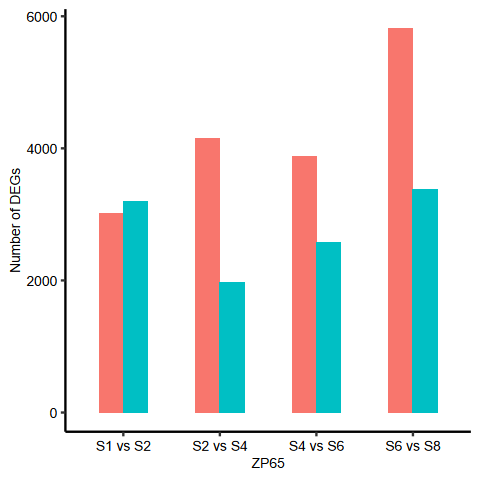

In [44]:
options(repr.plot.width=4, repr.plot.height=4)
Figure5C <- zp44_zp65_DEGs %>%
    dplyr::filter(group!="None") %>%
    dplyr::filter(grepl("ZP65",comparison)) %>%
    mutate(comparison=gsub("ZP65-","",comparison)) %>%
    group_by(comparison,group) %>%
    summarise(Number=n()) %>%
    ggplot(aes(comparison,Number,fill=group))+
        geom_bar(stat='identity',position=position_dodge(),width=0.5)+
        theme(axis.text=element_text(size=8,color='black'),
              axis.text.x=element_text(size=8,color='black',angle=0),
              axis.title=element_text(size=8),
              panel.background = element_blank(),
              legend.position='none',strip.text = element_text(size = 8, colour = "black"),
              #strip.background = element_rect(color="white",fill='white'),
             axis.line = element_line(colour = "black",size = 0.5))+
xlab("ZP65")+ylab("Number of DEGs")
Figure5C

In [45]:
MM_GS <- NULL
MM_GS_cor <- NULL
for(module in unique(net$colors)){
    genes <- names(net$color)[net$color==module]
    module <- paste0("ME",module)
    module_gene <- geneModuleMembership[genes,module]
    Pvalue <- MMPvalue[genes,module]
    re <- data.frame(gene=genes,MM=module_gene,module,MMPvalue=Pvalue)
    for(samples in colnames(trait)){
        re$samples <- samples
        re$GS <- geneTraitSignificance[genes,samples]
        re$GSPvalue <- GSPvalue[genes,samples]
        MM_GS <- rbind(MM_GS,re)
        corrr <- as.numeric(cor(abs(re$MM),abs(re$GS),method='pearson'))
        re2 <- data.frame(module=unique(re$module),samples=unique(re$samples),cor=corrr)
        MM_GS_cor <- rbind(MM_GS_cor,re2)
    }
}

In [46]:
pairs <- c("ZP65-S8 vs ME9","ZP44-S8 vs ME0","ZP44-S8 vs ME4","ZP65-S6 vs ME0","ZP65-S6 vs ME11","ZP65-S6 vs ME12","ZP65-S6 vs ME14","ZP44-S6 vs ME5","ZP44-S6 vs ME7","ZP44-S6 vs ME10","ZP65-S4 vs ME11","ZP65-S4 vs ME12","ZP44-S4 vs ME7","ZP65-S2 vs ME7","ZP65-S2 vs ME11","ZP44-S2 vs ME7","ZP44-S2 vs ME8","ZP44-S2 vs ME11","ZP44-S2 vs ME15","ZP65-S1 vs ME17","ZP44-S1 vs ME7","ZP44-S1 vs ME11","ZP44-S1 vs ME15")

In [47]:
pairs2 <- c("ZP65-S8 vs ME9","ZP44-S8 vs ME0","ZP44-S8 vs ME4","ZP65-S6 vs ME12","ZP65-S6 vs ME14","ZP44-S6 vs ME5","ZP44-S6 vs ME10","ZP65-S4 vs ME12","ZP65-S2 vs ME11","ZP44-S2 vs ME7","ZP44-S2 vs ME8","ZP44-S2 vs ME11","ZP44-S2 vs ME15","ZP65-S1 vs ME17","ZP44-S1 vs ME7","ZP44-S1 vs ME11")

In [48]:
colors <- c("#FFB6C1","#DB7093","#C71585","#DA70D6","#8B008B","#9370DB","#483D8B","#B0C4DE",
                                   "#4169E1","#4682B4","#5F9EA0","#00CED1","#008080","#3CB371","#3A97CA","#FFD700")

In [49]:
QTL.gene <- read.table("03_vcf//Fst//QTL.gene")
QTL.gene <- unique(QTL.gene$V7)
QTL.gene <- lapply(QTL.gene,function(x){
    gene <- unlist(str_split(x,"\\."))[1]
})
QTL.gene <- unlist(QTL.gene)
QTL.gene <- data.frame(Gene=QTL.gene,type='QTL')

In [50]:
Fst_top5.gene <- read.table("03_vcf//Fst//Fst_top5.gene")
Fst_top5.gene <- unique(Fst_top5.gene$V7)
Fst_top5.gene <- lapply(Fst_top5.gene,function(x){
    gene <- unlist(str_split(x,"\\."))[1]
})
Fst_top5.gene <- unlist(Fst_top5.gene)
Fst_top5.gene <- data.frame(Gene=Fst_top5.gene,type='Fst top 5%')

In [51]:
pQTL.gene <- read.table("05_pQTL/pQTL.gene")
pQTL.gene <- unique(pQTL.gene$V1)
pQTL.gene <- lapply(pQTL.gene,function(x){
    gene <- unlist(str_split(x,"\\."))[1]
})
pQTL.gene <- unlist(pQTL.gene)
pQTL.gene <- data.frame(Gene=pQTL.gene,type='pQTL')

In [52]:
load("06_counts/DEGs.RData")

In [53]:
DEGs <- DEGs %>%
    dplyr::filter(group!="None")

In [54]:
DEGs <- data.frame(Gene=unique(DEGs$gene),type='DEGs')

In [55]:
load("06_counts/net.RData")

In [56]:
#参考Figure 5
need <- sort(unique(c(11,7,15,8,10,5,0,4,17,12,14,9)))

In [57]:
need

[1]  0  4  5  7  8  9 10 11 12 14 15 17

In [58]:
WGCNA.gene <- c()
for(me in need){
    genes <- names(net$colors)[net$colors==me]
    WGCNA.gene <- c(WGCNA.gene,genes)
}

In [59]:
WGCNA.gene <- unique(WGCNA.gene)
WGCNA.gene <- data.frame(Gene=WGCNA.gene,type='WGCNA')

In [60]:
zp44 <- zp44_zp65_DEGs$gene[grepl("ZP44",zp44_zp65_DEGs$comparison) & zp44_zp65_DEGs$group!="None"]
zp65 <- zp44_zp65_DEGs$gene[grepl("ZP65",zp44_zp65_DEGs$comparison) & zp44_zp65_DEGs$group!="None"]
zp44 <- unique(zp44)
zp65 <- unique(zp65)

In [61]:
zp44 <- zp44_zp65_DEGs %>%
    dplyr::filter(group!="None") %>%
    dplyr::filter(grepl("ZP44",comparison)) %>%
    dplyr::select(Gene=gene) %>%
    mutate(type="ZP44") %>%
    unique()

In [62]:
zp65 <- zp44_zp65_DEGs %>%
    dplyr::filter(group!="None") %>%
    dplyr::filter(grepl("ZP65",comparison)) %>%
    dplyr::select(Gene=gene) %>%
    mutate(type="ZP65") %>%
    unique()

In [63]:
target.genes <- rbind(QTL.gene,Fst_top5.gene,pQTL.gene,DEGs,WGCNA.gene,zp65)

In [64]:
target.genes <- target.genes %>%
    mutate(Number=TRUE) %>%
    spread(.,type,Number)

In [65]:
target.genes[is.na(target.genes)] <- FALSE

In [66]:
colnames(target.genes)[1] <- 'gene'

In [69]:
#save(target.genes,file="07_features/target_genes.RData")

Warning message:
"No shared levels found between `names(values)` of the manual scale and the data's colour values."


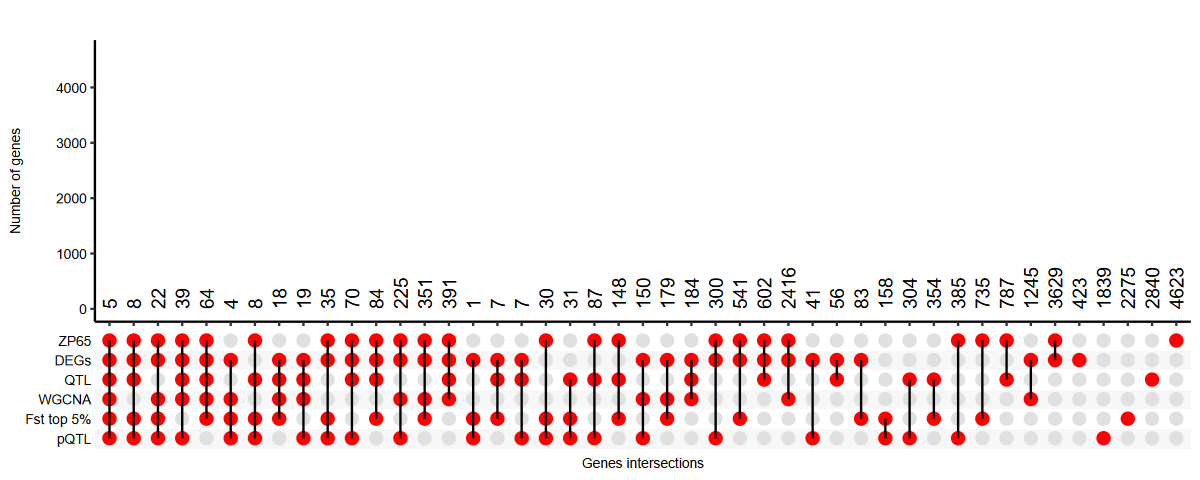

In [70]:
# 转换数据格式
data_long <- target.genes %>%
  pivot_longer(cols = -gene, names_to = "set", values_to = "member") %>%
  filter(member) %>%
  group_by(gene) %>%
  summarise(sets = list(set))
# 创建UpSet图
options(repr.plot.width=10, repr.plot.height=4)
Figure5D <- ggplot(data_long, aes(x = sets)) +
  geom_bar(fill = NA, color = NA) +
geom_text(stat = "count", aes(label = after_stat(count)), vjust = 0.5,hjust=0,angle=90,y=0)+    
scale_x_upset(order_by='degree',reverse=TRUE)+
scale_color_manual(values = c("DEGs" = "red"))+
  labs(
    title = "",
    x = "Genes intersections",
    y = "Number of genes"
  ) +
    theme(axis.text=element_text(size=8,color='black'),
              axis.title=element_text(size=8),
              panel.background = element_blank(),
              legend.position='right',strip.text = element_text(size = 8, colour = "black"),
              #strip.background = element_rect(color="white",fill='white'),
             axis.line = element_line(colour = "black",size = 0.5))+
    theme_combmatrix(combmatrix.label.text = element_text(color = "black", size=8),
                combmatrix.panel.point.color.fill = "red",
                combmatrix.panel.line.size = 0.5)
Figure5D

In [31]:
KOannotation <- read.delim("GO/SS_GOannotation.tsv", stringsAsFactors=FALSE)
genes <- lapply(KOannotation$gene,function(x){
    gene <- unlist(str_split(x,"\\."))[1]
    }
    )
KOannotation$gene <- unlist(genes)
KOinfo <- read.delim("GO//go.tb", stringsAsFactors=FALSE)
KOannotation = split(KOannotation, with(KOannotation, level))
KOkegg <- read.delim("KEGG/SS_KOannotation.tsv", stringsAsFactors=FALSE)
genes <- lapply(KOkegg$gene,function(x){
    gene <- unlist(str_split(x,"\\."))[1]
    }
    )
KOkegg$gene <- unlist(genes)

In [77]:
target.genes2 <- target.genes

In [78]:
target.genes2$Total <- apply(target.genes2[,-1],1,sum)

In [68]:
target.genes3 <- target.genes2 %>%
    arrange(desc(Total)) %>%
    dplyr::filter(Total>=5)

In [80]:
target.genes2 <- target.genes2 %>%
    arrange(desc(Total))

In [88]:
ll <- target.genes2 %>%
    dplyr::filter(Total>=4)

In [90]:
#write.csv(ll,"Tables/Table S6.csv",row.names=F)

In [84]:
cis <- read_excel("08_plantcare/plantCARE_output_PlantCARE_16297.xlsx")

`summarise()` has grouped output by 'Group', 'Gene'. You can override using the `.groups` argument.


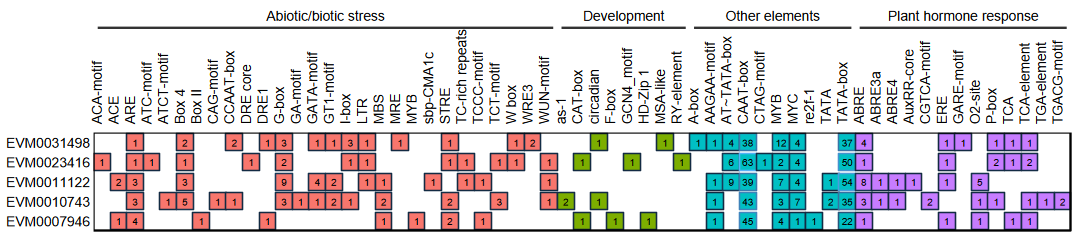

In [85]:
options(repr.plot.width=9, repr.plot.height=2)
Figure5E <- cis %>%
  dplyr::filter(!is.na(Motif) & Group!="Unknown functions") %>%
  dplyr::select(Gene,Motif,Group) %>%
  group_by(Group,Gene,Motif) %>%
  summarise(value=n()) %>%
  mutate(Group=gsub("cis-elements","",Group)) %>%
  ggplot(aes(interaction(Motif,Group),Gene,color=value,fill=Group))+
  geom_tile(color="white",fill="white")+
  geom_point(pch=22,size=5)+
  geom_text(aes(label=value),size=2,color="black")+
  labs(x = NULL,y = NULL,color=NULL)+
  scale_x_discrete(expand = c(0,0),position = 'top') +
  scale_y_discrete(expand=c(0,0),position="left")+
  theme(axis.text.x=element_text(color="black",angle=90,size=8,hjust=-0),
        axis.text.y=element_text(color="black",size=8),
        axis.ticks.x=element_blank(),
        axis.ticks.y=element_blank(), 
        panel.border=element_rect(fill=NA,color="black",size=0.5,linetype="solid"),
        ggh4x.axis.nestline.x = element_line(size = 0.5),
        ggh4x.axis.nesttext.x = element_text(colour = "black",size=8,angle =0,vjust=2,hjust=0.5),
        legend.position = "none",
        panel.background = element_blank())+
  guides(x='axis_nested')
Figure5E

Warning message:
"No shared levels found between `names(values)` of the manual scale and the data's colour values."


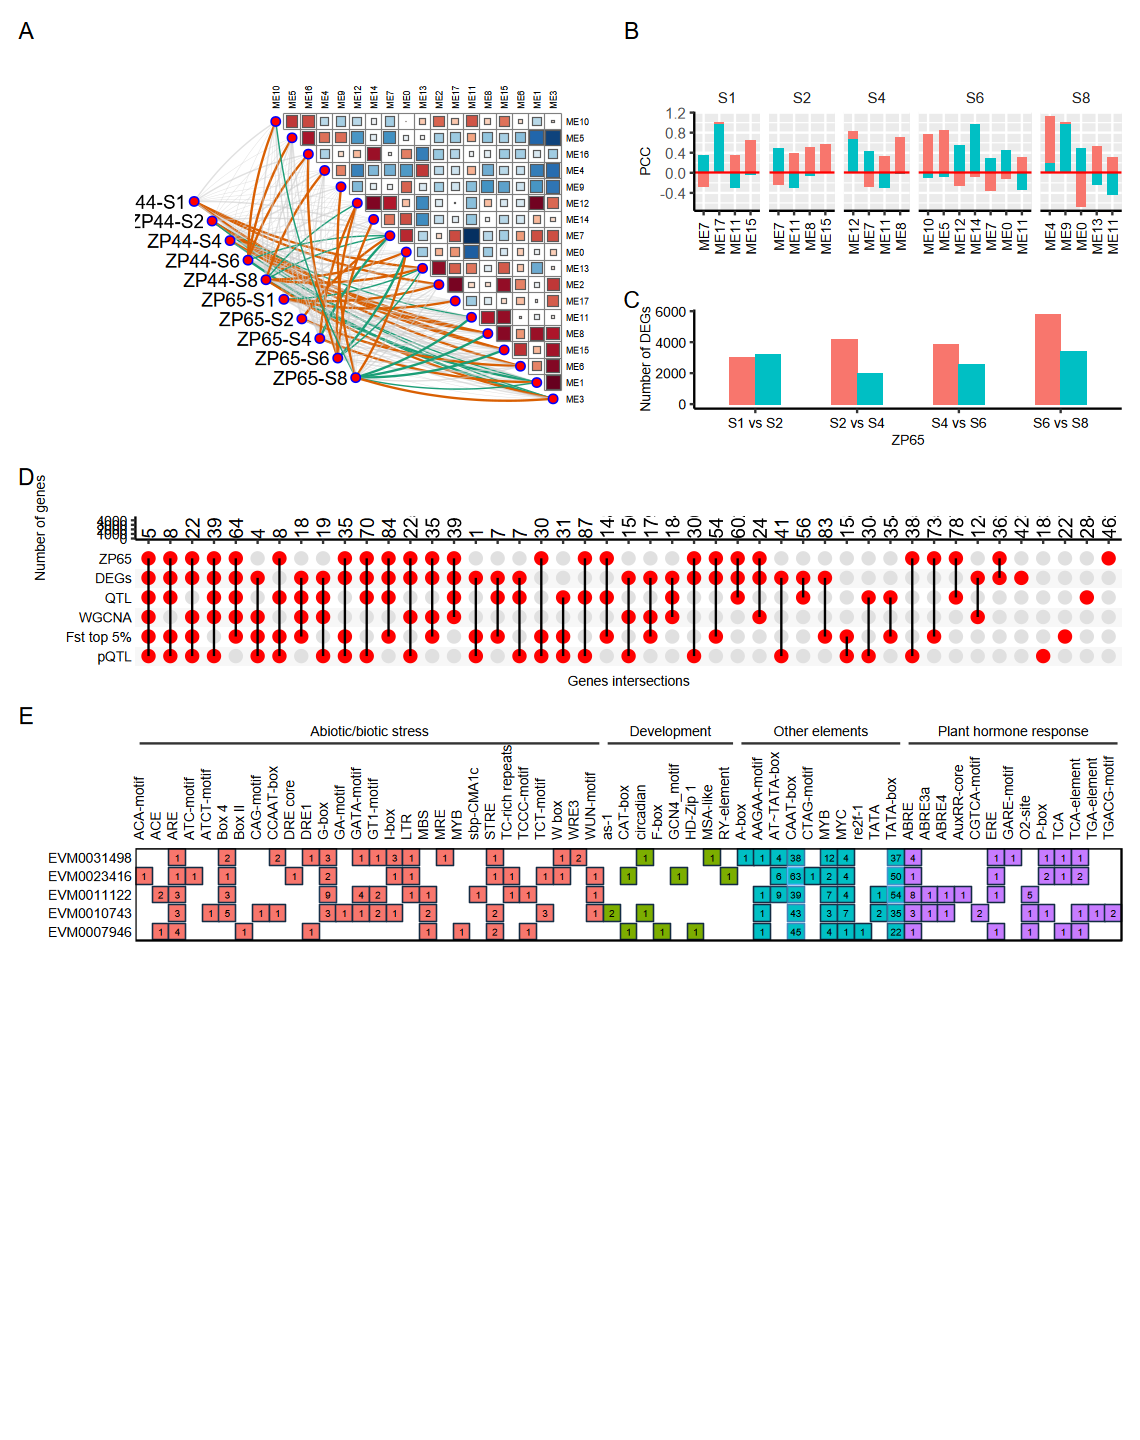

In [91]:
options(repr.plot.width=9.5, repr.plot.height=12)
((Figure5A|(Figure5B/Figure5C))/Figure5D/Figure5E/plot_spacer())+plot_layout(height=c(1.3,0.1,0.4,2))+plot_annotation(tag_levels = 'A')

In [92]:
#pdf("Figures\\Figure 55.pdf",width=9.5,height=12)
#options(repr.plot.width=9.5, repr.plot.height=12)
#((Figure5A|(Figure5B/Figure5C))/Figure5D/Figure5E/plot_spacer())+plot_layout(height=c(1.3,0.1,0.4,2))+plot_annotation(tag_levels = 'A')
#dev.off()

Warning message:
"No shared levels found between `names(values)` of the manual scale and the data's colour values."


pdf 
  2

In [29]:
need <- sort(unique(c(11,7,15,8,10,5,0,4,17,12,14,9)))

In [32]:
GO_result <- NULL
for(me in need){
    genes <- names(net$colors)[net$colors==me]
    for(j in c("biological_process","cellular_component","molecular_function")){
        print(j)
        ego <- enricher(genes,TERM2GENE=KOannotation[[j]][c(2,1)],TERM2NAME=KOinfo[1:2])
        ego <- data.frame(ego)
        ego <- ego[ego$p.adjust<0.05,]
        if(nrow(ego)==0){
            next
        }
        if(nrow(ego)>=5){
                ego <- ego[1:5,]
        }
        ego$enrichment <- j 
        GeneRatio <- lapply(ego$GeneRatio,function(x){
            x <- as.numeric(unlist(str_split(x,"/")))
            r <- x[1]/x[2]
        })
        ego$Ratio <- unlist(GeneRatio)
        ego$Module <- paste0("ME",me)
        GO_result <- rbind(GO_result,ego)
    } 
}

[1] "biological_process"
[1] "cellular_component"
[1] "molecular_function"
[1] "biological_process"
[1] "cellular_component"
[1] "molecular_function"
[1] "biological_process"
[1] "cellular_component"
[1] "molecular_function"
[1] "biological_process"
[1] "cellular_component"
[1] "molecular_function"
[1] "biological_process"
[1] "cellular_component"
[1] "molecular_function"
[1] "biological_process"
[1] "cellular_component"
[1] "molecular_function"
[1] "biological_process"
[1] "cellular_component"
[1] "molecular_function"
[1] "biological_process"
[1] "cellular_component"
[1] "molecular_function"
[1] "biological_process"
[1] "cellular_component"
[1] "molecular_function"
[1] "biological_process"
[1] "cellular_component"
[1] "molecular_function"
[1] "biological_process"
[1] "cellular_component"
[1] "molecular_function"
[1] "biological_process"
[1] "cellular_component"
[1] "molecular_function"


In [33]:
Enrich <- GO_result %>%
                arrange(Ratio) %>%
                mutate(inx=1:nrow(GO_result)) %>%
                mutate(inx=factor(inx))

In [35]:
#write.csv(Enrich,"Tables/Table S5.csv",row.names=F)

In [76]:
Enrich %>%
    dplyr::filter(Module %in% c('ME7','ME12','ME14')) ->ll

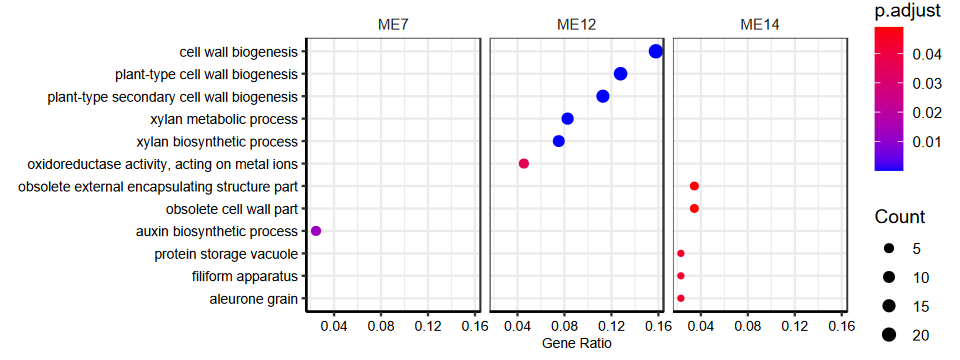

In [77]:
options(repr.plot.width=8, repr.plot.height=3)
FigureS5D <- Enrich %>%
    dplyr::filter(Module %in% c('ME7','ME12','ME14')) %>%
    mutate(Module=factor(Module,levels=c('ME7','ME12','ME14'))) %>%
    ggplot(aes(inx,Ratio,size=Count,color=p.adjust))+
        geom_point()+scale_size(range = c(1, 3))+
                        theme_bw()+
                        theme(axis.line = element_line(colour = "black",linewidth = 0.5),
                              strip.background =element_rect(colour = NA,fill = NA,linewidth = 1),
                        axis.text=element_text(size=8,color='black'),axis.title=element_text(size=8),
                        legend.position='right')+
                        coord_flip()+
                        xlab("")+
                        scale_color_gradient(low="blue",high="red")+
                        ylab('Gene Ratio')+
    scale_x_discrete(breaks=1:nrow(Enrich),labels=Enrich$Description)+
    facet_grid(~Module)
FigureS5D

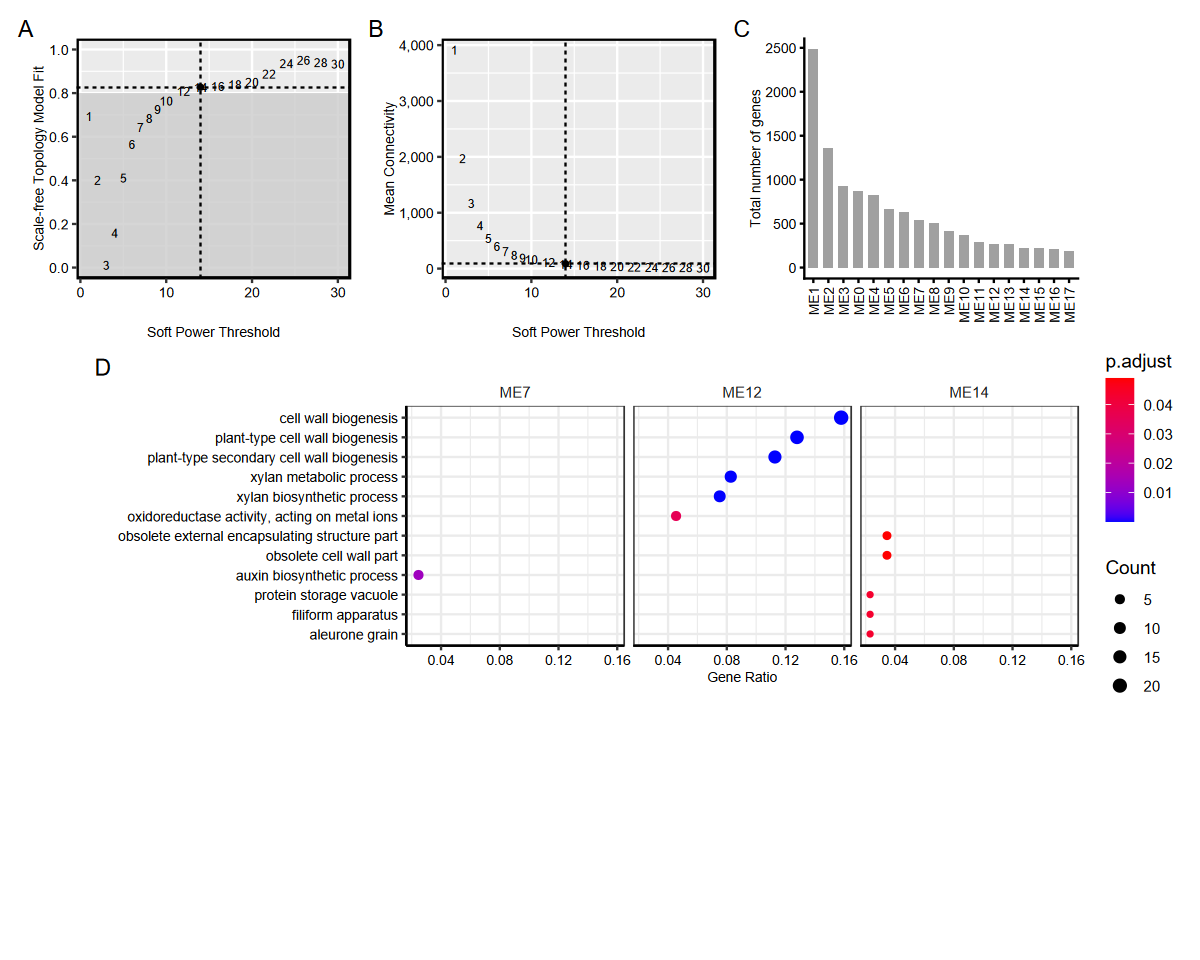

In [78]:
options(repr.plot.width=10, repr.plot.height=8)
(FigureS5A|FigureS5B|FigureS5C)/((plot_spacer()|FigureS5D)+plot_layout(width=c(0,1)))/plot_spacer()+plot_annotation(tag_levels = 'A')

In [60]:
#pdf("Figures\\Figure S5.pdf",width=10,height=8)
#(FigureS5A|FigureS5B|FigureS5C)/((plot_spacer()|FigureS5D)+plot_layout(width=c(0,1)))/plot_spacer()+plot_annotation(tag_levels = 'A')
#dev.off()

pdf 
  2